# **Extracting Dataset**

In [1]:
import os
import zipfile

zip_path = "/content/Dropped-Dataset.zip"
extract_path = "/content/Dataset2"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# **Importing Dependencies**

In [2]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.applications import DenseNet121, DenseNet201, EfficientNetV2L, InceptionResNetV2, DenseNet169
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
from typing import List, Tuple, Dict
from sklearn.utils.class_weight import compute_class_weight
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# **Constants**

In [3]:
# Constants
NUM_CLIENTS = 3
NUM_ROUNDS = 12
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
NUM_CLASSES = 3
CLASS_NAMES = ['Healthy', 'Moderate', 'Severe']
BASE_DIR = "/content/Dataset2/archive"

# **Client Data Class**

In [4]:
class ClientData:
    def __init__(self, generator, num_samples, class_weights):
        self.generator = generator
        self.num_samples = num_samples
        self.class_weights = class_weights

# **Load Image Files from each directory**

In [5]:
def get_class_dirs(base_path):
    """Get all image files from each class directory."""
    class_dirs = {}
    for class_name in CLASS_NAMES:
        class_path = os.path.join(base_path, 'train', class_name)
        image_files = [os.path.join(class_name, f) for f in os.listdir(class_path)
                      if f.endswith(('.png', '.jpg', '.jpeg'))]
        class_dirs[class_name] = image_files
    return class_dirs

# **Client Shards of data**

In [6]:
def create_client_shards():
    """Create client shards by dividing data among clients."""
    class_dirs = get_class_dirs(BASE_DIR)
    client_data = [[] for _ in range(NUM_CLIENTS)]
    client_sample_counts = [0] * NUM_CLIENTS

    # Distribute files from each class evenly among clients
    for class_name, files in class_dirs.items():
        np.random.shuffle(files)
        files_per_client = len(files) // NUM_CLIENTS

        for client_idx in range(NUM_CLIENTS):
            start_idx = client_idx * files_per_client
            end_idx = start_idx + files_per_client if client_idx < NUM_CLIENTS - 1 else len(files)
            client_files = files[start_idx:end_idx]
            client_data[client_idx].extend(client_files)
            client_sample_counts[client_idx] += len(client_files)

    return client_data, client_sample_counts

# **Data Generators**

In [7]:
def create_data_generator(is_training=True):
    """Create data generator with appropriate augmentation."""
    if is_training:
        return ImageDataGenerator(
            rescale=1./255,
            rotation_range=20,
            width_shift_range=0.2,
            height_shift_range=0.2,
            horizontal_flip=True,
            fill_mode='nearest'
        )
    return ImageDataGenerator(rescale=1./255)

# **Class Weights**

In [8]:
def compute_class_weights(client_data):
    """Compute class weights for balancing the classes."""
    all_labels = []
    for shard in client_data:
        for class_name in CLASS_NAMES:
            all_labels.extend([class_name] * len(shard))

    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(all_labels),
        y=all_labels
    )
    return {i: class_weights[i] for i in range(NUM_CLASSES)}

# **Client Generators**

In [9]:
def create_client_generators(client_shards, client_sample_counts):
    """Create data generators for each client's shard."""
    train_datagen = create_data_generator(is_training=True)
    client_generators = []

    for client_idx, (shard, num_samples) in enumerate(zip(client_shards, client_sample_counts)):
        # Create generator for this client
        generator = train_datagen.flow_from_directory(
            os.path.join(BASE_DIR, 'train'),
            target_size=IMG_SIZE,
            batch_size=BATCH_SIZE,
            class_mode='categorical',
            shuffle=True,
            classes=CLASS_NAMES
        )

        class_weights = compute_class_weights(shard)
        client_generators.append(ClientData(generator, num_samples, class_weights))

    return client_generators

# **Validation Test and AutoTest Generators**

In [10]:
def load_validation_test_data():
    """Load validation and test data."""
    val_datagen = create_data_generator(is_training=False)

    val_generator = val_datagen.flow_from_directory(
        os.path.join(BASE_DIR, 'val'),
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False
    )

    test_generator = val_datagen.flow_from_directory(
        os.path.join(BASE_DIR, 'test'),
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False
    )

    autotest_generator = val_datagen.flow_from_directory(
        os.path.join(BASE_DIR,'auto_test'),
        target_size = IMG_SIZE,
        batch_size = BATCH_SIZE,
        class_mode = 'categorical',
        shuffle = False
    )

    return val_generator, test_generator, autotest_generator

# **Inception-ResNet Model**

In [11]:
def create_inception_resnet_model():
    """Create and compile the InceptionResNetV2 model."""
    base_model = InceptionResNetV2(
        weights='imagenet',
        include_top=False,
        input_shape=(*IMG_SIZE, 3)
    )

    base_model.trainable = False

    model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# **DenseNet201 Model**

In [12]:
def create_densenet201_model():
    """Create and compile the DenseNet201 Model."""
    base_model = DenseNet201(
        weights='imagenet',
        include_top=False,
        input_shape=(*IMG_SIZE, 3)
    )

    base_model.trainable = False

    model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# **DenseNet169 Model**

In [13]:
def create_densenet169_model():
    """Create and compile the DenseNet169 model."""
    base_model = DenseNet169(
        weights='imagenet',
        include_top=False,
        input_shape=(*IMG_SIZE, 3)
    )

    base_model.trainable = False

    model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# **Client Training**

In [14]:
def client_update(model, client_data: ClientData):
    """Train the model on client data."""
    steps = client_data.num_samples // BATCH_SIZE

    history = model.fit(
        client_data.generator,
        steps_per_epoch=steps,
        epochs=1,
        verbose=0,
        class_weight=client_data.class_weights
    )
    return model.get_weights(), history.history['accuracy'][0]

# **FedAverage Algorithm**

In [15]:
def weighted_average_weights(weights_list: List[np.ndarray],
                           sample_counts: List[int]) -> List[np.ndarray]:
    """Compute weighted average of model weights based on number of samples."""
    total_samples = sum(sample_counts)
    weight_scaling_factors = [count / total_samples for count in sample_counts]

    avg_weights = []
    for layer_weights in zip(*weights_list):
        layer_weights = np.array(layer_weights)
        scaled_weights = np.array([w * scale for w, scale in zip(layer_weights, weight_scaling_factors)])
        avg_weights.append(np.sum(scaled_weights, axis=0))

    return avg_weights

# **Main Training**

**1. DenseNet201 Model**

DenseNet201 Model
--------------------------------------------------
Creating client shards...
Creating data generators...
Found 3216 images belonging to 3 classes.
Found 3216 images belonging to 3 classes.
Found 3216 images belonging to 3 classes.
Found 461 images belonging to 3 classes.
Found 913 images belonging to 3 classes.
Found 848 images belonging to 3 classes.

Client data distribution:
Client 1: 1071 samples (33.3%)
Client 2: 1071 samples (33.3%)
Client 3: 1074 samples (33.4%)

Creating global model...
74836368/74836368 [==============================] - 0s 0us/step

Starting federated learning...
--------------------------------------------------

Round 1/12
------------------------------
Training Client 1...


<ipython-input-16-87dafdd477f7>:58: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  accuracies_df = pd.concat([accuracies_df, new_row], ignore_index=True)


Client 1 Accuracy: 0.7596
Training Client 2...
Client 2 Accuracy: 0.7576
Training Client 3...
Client 3 Accuracy: 0.7481

Round Summary:
Average Client Accuracy: 0.7551
Global Model Accuracy: 0.8069
Global Model Loss: 0.4580
------------------------------

Round 2/12
------------------------------
Training Client 1...
Client 1 Accuracy: 0.8011
Training Client 2...
Client 2 Accuracy: 0.7879
Training Client 3...
Client 3 Accuracy: 0.8125

Round Summary:
Average Client Accuracy: 0.8005
Global Model Accuracy: 0.8438
Global Model Loss: 0.4046
------------------------------

Round 3/12
------------------------------
Training Client 1...
Client 1 Accuracy: 0.8078
Training Client 2...
Client 2 Accuracy: 0.8077
Training Client 3...
Client 3 Accuracy: 0.8011

Round Summary:
Average Client Accuracy: 0.8055
Global Model Accuracy: 0.8438
Global Model Loss: 0.3964
------------------------------

Round 4/12
------------------------------
Training Client 1...
Client 1 Accuracy: 0.8058
Training Client 2

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Final Test Results:
--------------------
Test Loss: 0.3518
Test Accuracy: 0.8510

AutoTest Results:
--------------------
Test Loss: 0.3322
Test Accuracy: 0.8703
29/29 [==============================] - 27s 818ms/step

Test dataset - Classification Report:
              precision    recall  f1-score   support

     Healthy       0.89      0.98      0.93       639
    Moderate       0.79      0.55      0.65       223
      Severe       0.52      0.59      0.55        51

    accuracy                           0.85       913
   macro avg       0.73      0.70      0.71       913
weighted avg       0.85      0.85      0.84       913

27/27 [==============================] - 22s 801ms/step

Autotest dataset - Classification Report:
              precision    recall  f1-score   support

     Healthy       0.90      0.99      0.94       604
    Moderate       0.85      0.56      0.68       200
      Severe       0.57      0.70      0.63        44

    accuracy                           0.87  

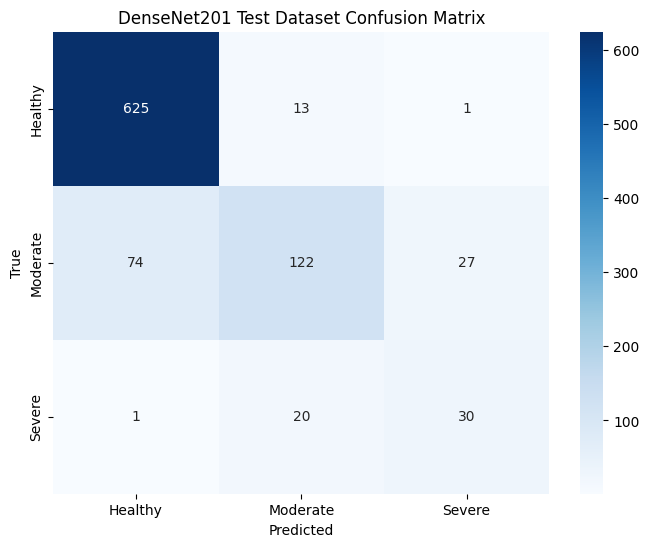


Autotest dataset - Confusion Matrix:


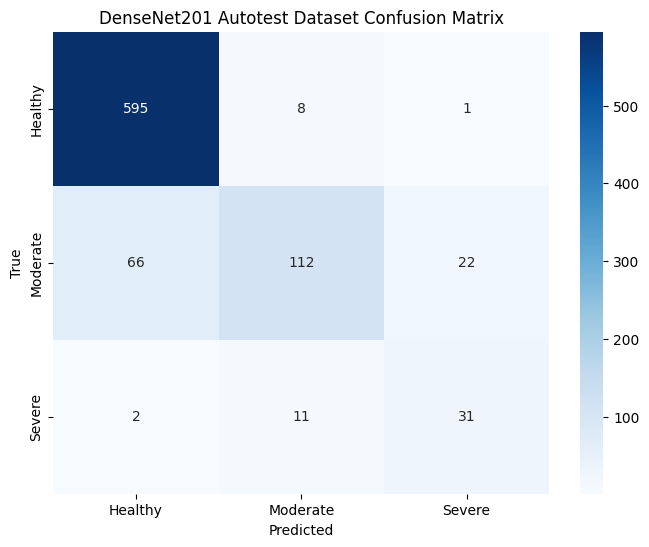

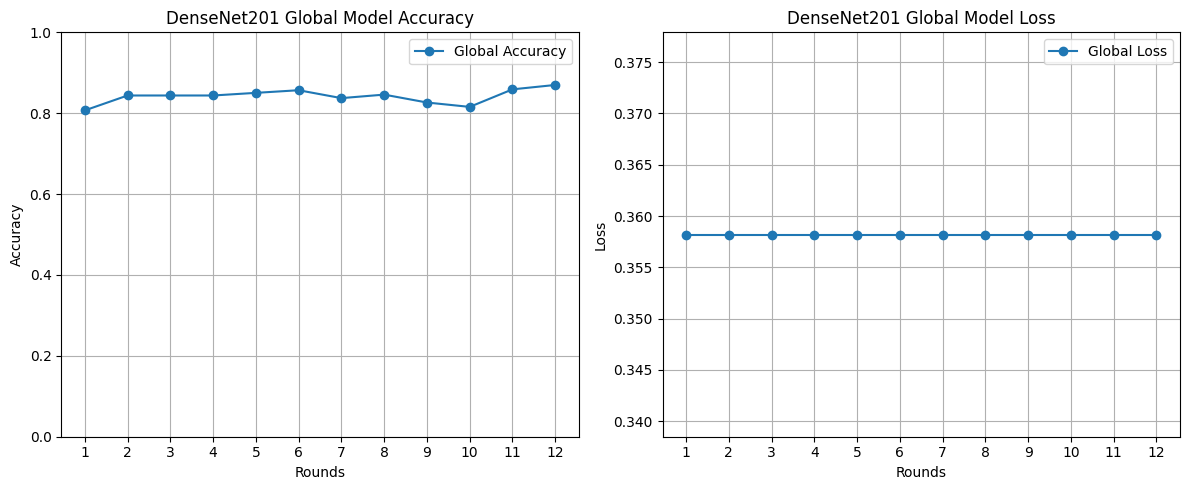

In [16]:
MODEL_NAME = "DenseNet201"  # Set your model name here
print("DenseNet201 Model")
print("-" * 50)

def main():
    print("Creating client shards...")
    client_shards, client_sample_counts = create_client_shards()

    print("Creating data generators...")
    client_data_list = create_client_generators(client_shards, client_sample_counts)
    val_generator, test_generator, autotest_generator = load_validation_test_data()

    print("\nClient data distribution:")
    total_samples = sum(client_sample_counts)
    for i, count in enumerate(client_sample_counts):
        print(f"Client {i + 1}: {count} samples ({count / total_samples * 100:.1f}%)")

    print("\nCreating global model...")
    global_model = create_densenet201_model()

    print("\nStarting federated learning...")
    print("-" * 50)

    client_accuracies_history = []
    global_accuracies_history = []

    # DataFrame to store accuracies
    accuracies_df = pd.DataFrame(columns=['Round', 'Client', 'Client Accuracy', 'Global Accuracy'])

    # Federated Learning Loop
    for round_num in range(NUM_ROUNDS):
        print(f"\nRound {round_num + 1}/{NUM_ROUNDS}")
        print("-" * 30)

        client_weights = []
        round_client_accuracies = []

        # Train each client
        for client_idx, client_data in enumerate(client_data_list):
            print(f"Training Client {client_idx + 1}...")

            # Initialize client model with global weights
            client_model = create_densenet201_model()
            client_model.set_weights(global_model.get_weights())

            # Train on client's shard
            updated_weights, client_accuracy = client_update(client_model, client_data)

            client_weights.append(updated_weights)
            round_client_accuracies.append(client_accuracy)

            # Append to DataFrame
            new_row = pd.DataFrame({
                'Round': [round_num + 1],
                'Client': [client_idx + 1],
                'Client Accuracy': [client_accuracy]
            })
            accuracies_df = pd.concat([accuracies_df, new_row], ignore_index=True)

            print(f"Client {client_idx + 1} Accuracy: {client_accuracy:.4f}")

        # Store metrics
        client_accuracies_history.append(round_client_accuracies)

        # Compute weighted average of client weights
        global_weights = weighted_average_weights(client_weights, client_sample_counts)
        global_model.set_weights(global_weights)

        # Evaluate global model
        global_metrics = global_model.evaluate(val_generator, verbose=0)
        global_accuracies_history.append(global_metrics[1])

        # Append global accuracy to DataFrame
        accuracies_df.loc[accuracies_df['Round'] == (round_num + 1), 'Global Accuracy'] = global_metrics[1]

        print("\nRound Summary:")
        print(f"Average Client Accuracy: {np.mean(round_client_accuracies):.4f}")
        print(f"Global Model Accuracy: {global_metrics[1]:.4f}")
        print(f"Global Model Loss: {global_metrics[0]:.4f}")
        print("-" * 30)

    # Save the global model
    global_model.save(f"{MODEL_NAME}.h5")

    # Final evaluation
    final_metrics = global_model.evaluate(test_generator, verbose=0)
    print("\nFinal Test Results:")
    print("-" * 20)
    print(f"Test Loss: {final_metrics[0]:.4f}")
    print(f"Test Accuracy: {final_metrics[1]:.4f}")

    # Autotest Evaluation
    autotest_metrics = global_model.evaluate(autotest_generator,verbose=0)
    print("\nAutoTest Results:")
    print("-" * 20)
    print(f"Test Loss: {autotest_metrics[0]:.4f}")
    print(f"Test Accuracy: {autotest_metrics[1]:.4f}")

    # Print test dataset classification report
    y_true = test_generator.classes
    y_pred = np.argmax(global_model.predict(test_generator), axis=1)
    print("\nTest dataset - Classification Report:")
    print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

    # Print autotest dataset classification report
    y_true_auto = autotest_generator.classes
    y_pred_auto = np.argmax(global_model.predict(autotest_generator),axis=1)
    print("\nAutotest dataset - Classification Report:")
    print(classification_report(y_true_auto, y_pred_auto, target_names=autotest_generator.class_indices.keys()))

    # Plot Test dataset confusion matrix
    print("\nTest dataset - Confusion Matrix:")
    conf_matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=test_generator.class_indices.keys(),
                yticklabels=test_generator.class_indices.keys())
    plt.title(f'{MODEL_NAME} Test Dataset Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig(f"{MODEL_NAME}_test_confusion_matrix.png")
    plt.show()

    # Plot autotest dataset - confusion matrix
    print("\nAutotest dataset - Confusion Matrix:")
    conf_matrix = confusion_matrix(y_true_auto, y_pred_auto)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=autotest_generator.class_indices.keys(),
                yticklabels=autotest_generator.class_indices.keys())
    plt.title(f'{MODEL_NAME} Autotest Dataset Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig(f"{MODEL_NAME}_autotest_confusion_matrix.png")
    plt.show()


    # Plot global model accuracy and loss for each round
    rounds = np.arange(1, NUM_ROUNDS + 1)
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(rounds, global_accuracies_history, marker='o', label='Global Accuracy')
    plt.title(f'{MODEL_NAME} Global Model Accuracy')
    plt.xlabel('Rounds')
    plt.ylabel('Accuracy')
    plt.xticks(rounds)
    plt.ylim([0, 1])
    plt.grid()
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(rounds, [global_metrics[0]] * NUM_ROUNDS, marker='o', label='Global Loss')
    plt.title(f'{MODEL_NAME} Global Model Loss')
    plt.xlabel('Rounds')
    plt.ylabel('Loss')
    plt.xticks(rounds)
    plt.grid()
    plt.legend()

    plt.tight_layout()
    plt.savefig(f"{MODEL_NAME}_global_accuracy_loss.png")
    plt.show()

    # Save accuracies DataFrame to a CSV file
    accuracies_df.to_csv(f"{MODEL_NAME}_accuracies.csv", index=False)

if __name__ == "__main__":
    main()

**2. DenseNet169 Model**

DenseNet169 Model
--------------------------------------------------
Creating client shards...
Creating data generators...
Found 3216 images belonging to 3 classes.
Found 3216 images belonging to 3 classes.
Found 3216 images belonging to 3 classes.
Found 461 images belonging to 3 classes.
Found 913 images belonging to 3 classes.
Found 848 images belonging to 3 classes.

Client data distribution:
Client 1: 1071 samples (33.3%)
Client 2: 1071 samples (33.3%)
Client 3: 1074 samples (33.4%)

Creating global model...
51877672/51877672 [==============================] - 1s 0us/step

Starting federated learning...
--------------------------------------------------

Round 1/12
------------------------------
Training Client 1...


<ipython-input-17-94369f66a90a>:58: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  accuracies_df = pd.concat([accuracies_df, new_row], ignore_index=True)


Client 1 Accuracy: 0.6970
Training Client 2...
Client 2 Accuracy: 0.6960
Training Client 3...
Client 3 Accuracy: 0.7048

Round Summary:
Average Client Accuracy: 0.6993
Global Model Accuracy: 0.7310
Global Model Loss: 0.5817
------------------------------

Round 2/12
------------------------------
Training Client 1...
Client 1 Accuracy: 0.7386
Training Client 2...
Client 2 Accuracy: 0.7320
Training Client 3...
Client 3 Accuracy: 0.7510

Round Summary:
Average Client Accuracy: 0.7405
Global Model Accuracy: 0.7896
Global Model Loss: 0.5021
------------------------------

Round 3/12
------------------------------
Training Client 1...
Client 1 Accuracy: 0.7822
Training Client 2...
Client 2 Accuracy: 0.7689
Training Client 3...
Client 3 Accuracy: 0.7699

Round Summary:
Average Client Accuracy: 0.7737
Global Model Accuracy: 0.8026
Global Model Loss: 0.4797
------------------------------

Round 4/12
------------------------------
Training Client 1...
Client 1 Accuracy: 0.7760
Training Client 2

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Final Test Results:
--------------------
Test Loss: 0.4182
Test Accuracy: 0.8379

AutoTest Results:
--------------------
Test Loss: 0.3786
Test Accuracy: 0.8479
29/29 [==============================] - 21s 638ms/step

Test dataset - Classification Report:
              precision    recall  f1-score   support

     Healthy       0.87      0.97      0.92       639
    Moderate       0.72      0.57      0.64       223
      Severe       0.71      0.29      0.42        51

    accuracy                           0.84       913
   macro avg       0.77      0.61      0.66       913
weighted avg       0.83      0.84      0.82       913

27/27 [==============================] - 17s 607ms/step

Autotest dataset - Classification Report:
              precision    recall  f1-score   support

     Healthy       0.88      0.98      0.92       604
    Moderate       0.73      0.57      0.64       200
      Severe       0.78      0.32      0.45        44

    accuracy                           0.85  

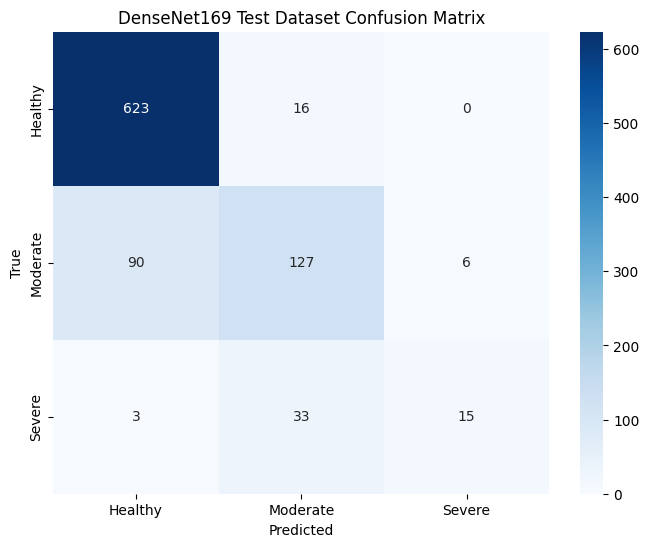


Autotest dataset - Confusion Matrix:


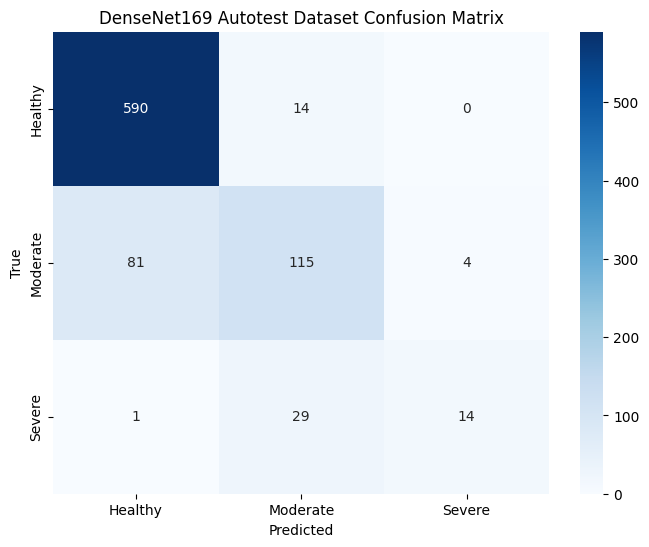

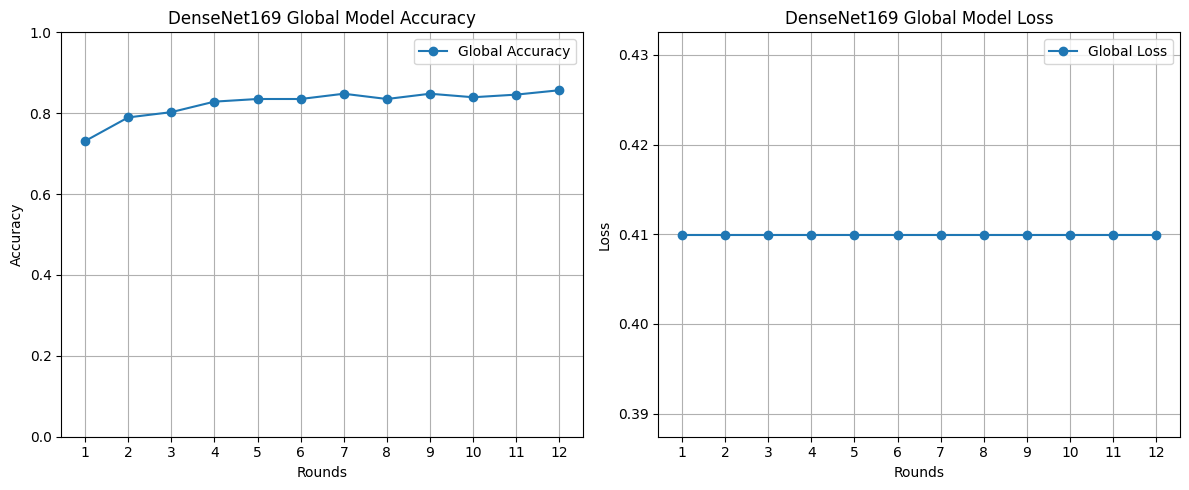

In [17]:
MODEL_NAME = "DenseNet169"  # Set your model name here
print("DenseNet169 Model")
print("-" * 50)

def main():
    print("Creating client shards...")
    client_shards, client_sample_counts = create_client_shards()

    print("Creating data generators...")
    client_data_list = create_client_generators(client_shards, client_sample_counts)
    val_generator, test_generator,autotest_generator = load_validation_test_data()

    print("\nClient data distribution:")
    total_samples = sum(client_sample_counts)
    for i, count in enumerate(client_sample_counts):
        print(f"Client {i + 1}: {count} samples ({count / total_samples * 100:.1f}%)")

    print("\nCreating global model...")
    global_model = create_densenet169_model()

    print("\nStarting federated learning...")
    print("-" * 50)

    client_accuracies_history = []
    global_accuracies_history = []

    # DataFrame to store accuracies
    accuracies_df = pd.DataFrame(columns=['Round', 'Client', 'Client Accuracy', 'Global Accuracy'])

    # Federated Learning Loop
    for round_num in range(NUM_ROUNDS):
        print(f"\nRound {round_num + 1}/{NUM_ROUNDS}")
        print("-" * 30)

        client_weights = []
        round_client_accuracies = []

        # Train each client
        for client_idx, client_data in enumerate(client_data_list):
            print(f"Training Client {client_idx + 1}...")

            # Initialize client model with global weights
            client_model = create_densenet169_model()
            client_model.set_weights(global_model.get_weights())

            # Train on client's shard
            updated_weights, client_accuracy = client_update(client_model, client_data)

            client_weights.append(updated_weights)
            round_client_accuracies.append(client_accuracy)

            # Append to DataFrame
            new_row = pd.DataFrame({
                'Round': [round_num + 1],
                'Client': [client_idx + 1],
                'Client Accuracy': [client_accuracy]
            })
            accuracies_df = pd.concat([accuracies_df, new_row], ignore_index=True)

            print(f"Client {client_idx + 1} Accuracy: {client_accuracy:.4f}")

        # Store metrics
        client_accuracies_history.append(round_client_accuracies)

        # Compute weighted average of client weights
        global_weights = weighted_average_weights(client_weights, client_sample_counts)
        global_model.set_weights(global_weights)

        # Evaluate global model
        global_metrics = global_model.evaluate(val_generator, verbose=0)
        global_accuracies_history.append(global_metrics[1])

        # Append global accuracy to DataFrame
        accuracies_df.loc[accuracies_df['Round'] == (round_num + 1), 'Global Accuracy'] = global_metrics[1]

        print("\nRound Summary:")
        print(f"Average Client Accuracy: {np.mean(round_client_accuracies):.4f}")
        print(f"Global Model Accuracy: {global_metrics[1]:.4f}")
        print(f"Global Model Loss: {global_metrics[0]:.4f}")
        print("-" * 30)

    # Save the global model
    global_model.save(f"{MODEL_NAME}.h5")

    # Final evaluation
    final_metrics = global_model.evaluate(test_generator, verbose=0)
    print("\nFinal Test Results:")
    print("-" * 20)
    print(f"Test Loss: {final_metrics[0]:.4f}")
    print(f"Test Accuracy: {final_metrics[1]:.4f}")

    # Autotest Evaluation
    autotest_metrics = global_model.evaluate(autotest_generator,verbose=0)
    print("\nAutoTest Results:")
    print("-" * 20)
    print(f"Test Loss: {autotest_metrics[0]:.4f}")
    print(f"Test Accuracy: {autotest_metrics[1]:.4f}")

    # Print test dataset classification report
    y_true = test_generator.classes
    y_pred = np.argmax(global_model.predict(test_generator), axis=1)
    print("\nTest dataset - Classification Report:")
    print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

    # Print autotest dataset classification report
    y_true_auto = autotest_generator.classes
    y_pred_auto = np.argmax(global_model.predict(autotest_generator),axis=1)
    print("\nAutotest dataset - Classification Report:")
    print(classification_report(y_true_auto, y_pred_auto, target_names=autotest_generator.class_indices.keys()))

    # Plot confusion matrix
    print("\nTest Dataset Confusion Matrix:")
    conf_matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=test_generator.class_indices.keys(),
                yticklabels=test_generator.class_indices.keys())
    plt.title(f'{MODEL_NAME} Test Dataset Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig(f"{MODEL_NAME}_test_confusion_matrix.png")
    plt.show()

    # Plot autotest dataset - confusion matrix
    print("\nAutotest dataset - Confusion Matrix:")
    conf_matrix = confusion_matrix(y_true_auto, y_pred_auto)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=autotest_generator.class_indices.keys(),
                yticklabels=autotest_generator.class_indices.keys())
    plt.title(f'{MODEL_NAME} Autotest Dataset Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig(f"{MODEL_NAME}_autotest_confusion_matrix.png")
    plt.show()


    # Plot global model accuracy and loss for each round
    rounds = np.arange(1, NUM_ROUNDS + 1)
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(rounds, global_accuracies_history, marker='o', label='Global Accuracy')
    plt.title(f'{MODEL_NAME} Global Model Accuracy')
    plt.xlabel('Rounds')
    plt.ylabel('Accuracy')
    plt.xticks(rounds)
    plt.ylim([0, 1])
    plt.grid()
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(rounds, [global_metrics[0]] * NUM_ROUNDS, marker='o', label='Global Loss')
    plt.title(f'{MODEL_NAME} Global Model Loss')
    plt.xlabel('Rounds')
    plt.ylabel('Loss')
    plt.xticks(rounds)
    plt.grid()
    plt.legend()

    plt.tight_layout()
    plt.savefig(f"{MODEL_NAME}_global_accuracy_loss.png")
    plt.show()

    # Save accuracies DataFrame to a CSV file
    accuracies_df.to_csv(f"{MODEL_NAME}_accuracies.csv", index=False)

if __name__ == "__main__":
    main()

**3. Inception-ResNet V2 Model**

InceptionResNet Model
--------------------------------------------------
Creating client shards...
Creating data generators...
Found 3216 images belonging to 3 classes.
Found 3216 images belonging to 3 classes.
Found 3216 images belonging to 3 classes.
Found 461 images belonging to 3 classes.
Found 913 images belonging to 3 classes.
Found 848 images belonging to 3 classes.

Client data distribution:
Client 1: 1071 samples (33.3%)
Client 2: 1071 samples (33.3%)
Client 3: 1074 samples (33.4%)

Creating global model...
219055592/219055592 [==============================] - 1s 0us/step

Starting federated learning...
--------------------------------------------------

Round 1/12
------------------------------
Training Client 1...


<ipython-input-18-e9142f9a4832>:58: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  accuracies_df = pd.concat([accuracies_df, new_row], ignore_index=True)


Client 1 Accuracy: 0.6203
Training Client 2...
Client 2 Accuracy: 0.6752
Training Client 3...
Client 3 Accuracy: 0.6487

Round Summary:
Average Client Accuracy: 0.6480
Global Model Accuracy: 0.7397
Global Model Loss: 0.6569
------------------------------

Round 2/12
------------------------------
Training Client 1...
Client 1 Accuracy: 0.7311
Training Client 2...
Client 2 Accuracy: 0.7140
Training Client 3...
Client 3 Accuracy: 0.7102

Round Summary:
Average Client Accuracy: 0.7184
Global Model Accuracy: 0.7701
Global Model Loss: 0.6931
------------------------------

Round 3/12
------------------------------
Training Client 1...
Client 1 Accuracy: 0.7405
Training Client 2...
Client 2 Accuracy: 0.7567
Training Client 3...
Client 3 Accuracy: 0.7225

Round Summary:
Average Client Accuracy: 0.7399
Global Model Accuracy: 0.7679
Global Model Loss: 0.5739
------------------------------

Round 4/12
------------------------------
Training Client 1...
Client 1 Accuracy: 0.7263
Training Client 2

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Final Test Results:
--------------------
Test Loss: 0.4760
Test Accuracy: 0.7941

AutoTest Results:
--------------------
Test Loss: 0.4474
Test Accuracy: 0.8184
29/29 [==============================] - 17s 475ms/step

Test dataset - Classification Report:
              precision    recall  f1-score   support

     Healthy       0.84      0.95      0.89       639
    Moderate       0.61      0.50      0.55       223
      Severe       0.67      0.12      0.20        51

    accuracy                           0.79       913
   macro avg       0.71      0.52      0.55       913
weighted avg       0.78      0.79      0.77       913

27/27 [==============================] - 13s 464ms/step

Autotest dataset - Classification Report:
              precision    recall  f1-score   support

     Healthy       0.86      0.97      0.91       604
    Moderate       0.65      0.54      0.59       200
      Severe       1.00      0.07      0.13        44

    accuracy                           0.82  

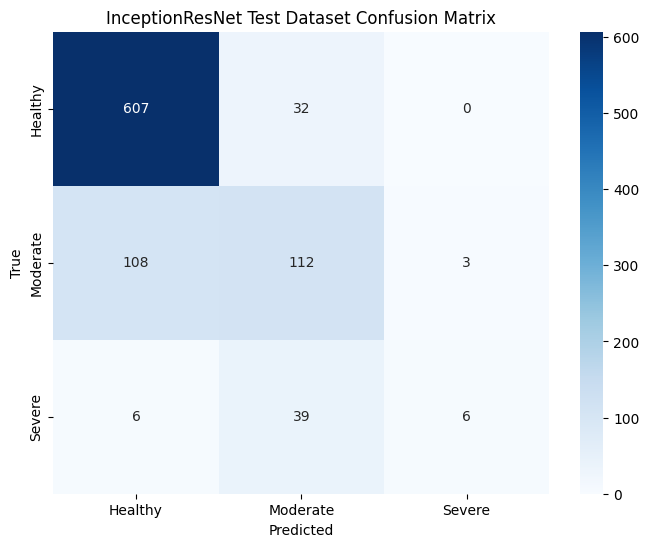


Autotest dataset - Confusion Matrix:


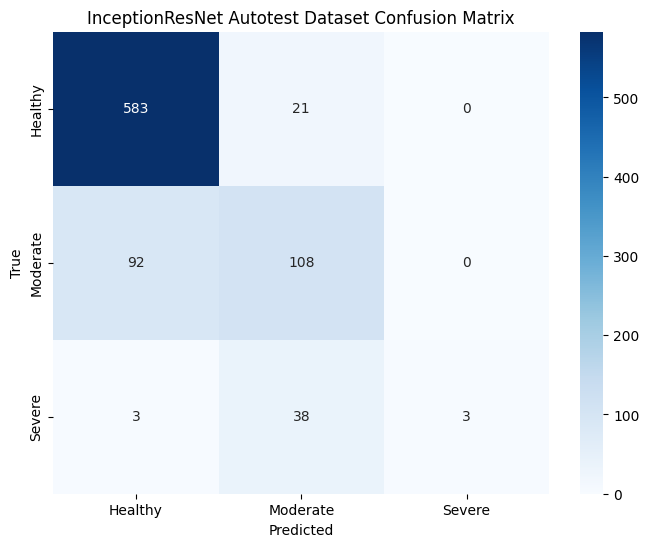

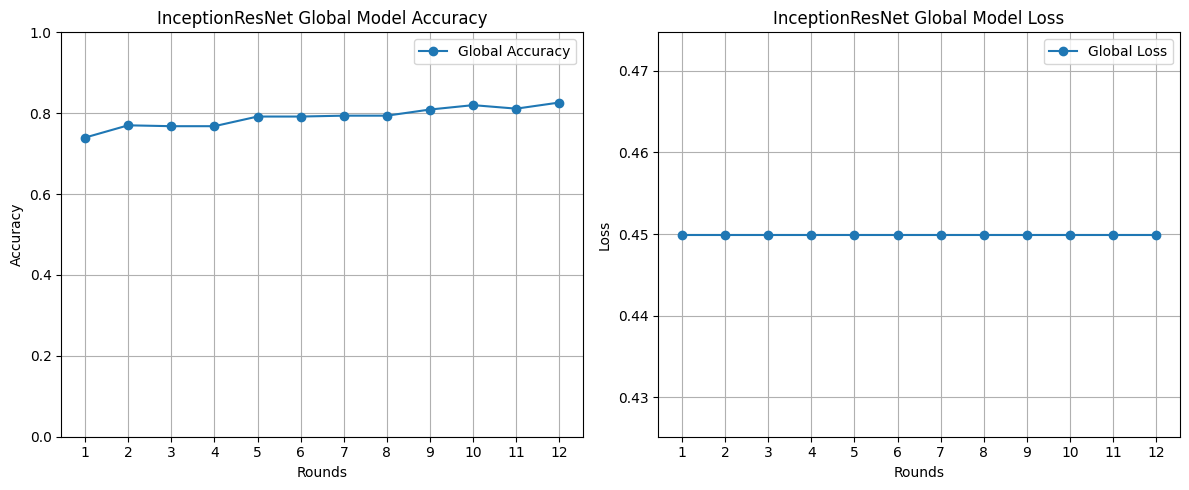

In [18]:
MODEL_NAME = "InceptionResNet"  # Set your model name here
print("InceptionResNet Model")
print("-" * 50)

def main():
    print("Creating client shards...")
    client_shards, client_sample_counts = create_client_shards()

    print("Creating data generators...")
    client_data_list = create_client_generators(client_shards, client_sample_counts)
    val_generator, test_generator,autotest_generator = load_validation_test_data()

    print("\nClient data distribution:")
    total_samples = sum(client_sample_counts)
    for i, count in enumerate(client_sample_counts):
        print(f"Client {i + 1}: {count} samples ({count / total_samples * 100:.1f}%)")

    print("\nCreating global model...")
    global_model = create_inception_resnet_model()

    print("\nStarting federated learning...")
    print("-" * 50)

    client_accuracies_history = []
    global_accuracies_history = []

    # DataFrame to store accuracies
    accuracies_df = pd.DataFrame(columns=['Round', 'Client', 'Client Accuracy', 'Global Accuracy'])

    # Federated Learning Loop
    for round_num in range(NUM_ROUNDS):
        print(f"\nRound {round_num + 1}/{NUM_ROUNDS}")
        print("-" * 30)

        client_weights = []
        round_client_accuracies = []

        # Train each client
        for client_idx, client_data in enumerate(client_data_list):
            print(f"Training Client {client_idx + 1}...")

            # Initialize client model with global weights
            client_model = create_inception_resnet_model()
            client_model.set_weights(global_model.get_weights())

            # Train on client's shard
            updated_weights, client_accuracy = client_update(client_model, client_data)

            client_weights.append(updated_weights)
            round_client_accuracies.append(client_accuracy)

            # Append to DataFrame
            new_row = pd.DataFrame({
                'Round': [round_num + 1],
                'Client': [client_idx + 1],
                'Client Accuracy': [client_accuracy]
            })
            accuracies_df = pd.concat([accuracies_df, new_row], ignore_index=True)

            print(f"Client {client_idx + 1} Accuracy: {client_accuracy:.4f}")

        # Store metrics
        client_accuracies_history.append(round_client_accuracies)

        # Compute weighted average of client weights
        global_weights = weighted_average_weights(client_weights, client_sample_counts)
        global_model.set_weights(global_weights)

        # Evaluate global model
        global_metrics = global_model.evaluate(val_generator, verbose=0)
        global_accuracies_history.append(global_metrics[1])

        # Append global accuracy to DataFrame
        accuracies_df.loc[accuracies_df['Round'] == (round_num + 1), 'Global Accuracy'] = global_metrics[1]

        print("\nRound Summary:")
        print(f"Average Client Accuracy: {np.mean(round_client_accuracies):.4f}")
        print(f"Global Model Accuracy: {global_metrics[1]:.4f}")
        print(f"Global Model Loss: {global_metrics[0]:.4f}")
        print("-" * 30)

    # Save the global model
    global_model.save(f"{MODEL_NAME}.h5")

    # Final evaluation
    final_metrics = global_model.evaluate(test_generator, verbose=0)
    print("\nFinal Test Results:")
    print("-" * 20)
    print(f"Test Loss: {final_metrics[0]:.4f}")
    print(f"Test Accuracy: {final_metrics[1]:.4f}")

    # Autotest Evaluation
    autotest_metrics = global_model.evaluate(autotest_generator,verbose=0)
    print("\nAutoTest Results:")
    print("-" * 20)
    print(f"Test Loss: {autotest_metrics[0]:.4f}")
    print(f"Test Accuracy: {autotest_metrics[1]:.4f}")

    # Print classification report
    y_true = test_generator.classes
    y_pred = np.argmax(global_model.predict(test_generator), axis=1)
    print("\nTest dataset - Classification Report:")
    print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

    # Print autotest dataset classification report
    y_true_auto = autotest_generator.classes
    y_pred_auto = np.argmax(global_model.predict(autotest_generator),axis=1)
    print("\nAutotest dataset - Classification Report:")
    print(classification_report(y_true_auto, y_pred_auto, target_names=autotest_generator.class_indices.keys()))

    # Plot test dataset confusion matrix
    print("\nTest dataset - Confusion Matrix:")
    conf_matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=test_generator.class_indices.keys(),
                yticklabels=test_generator.class_indices.keys())
    plt.title(f'{MODEL_NAME} Test Dataset Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig(f"{MODEL_NAME}_test_confusion_matrix.png")
    plt.show()

    # Plot autotest dataset - confusion matrix
    print("\nAutotest dataset - Confusion Matrix:")
    conf_matrix = confusion_matrix(y_true_auto, y_pred_auto)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=autotest_generator.class_indices.keys(),
                yticklabels=autotest_generator.class_indices.keys())
    plt.title(f'{MODEL_NAME} Autotest Dataset Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig(f"{MODEL_NAME}_autotest_confusion_matrix.png")
    plt.show()

    # Plot global model accuracy and loss for each round
    rounds = np.arange(1, NUM_ROUNDS + 1)
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(rounds, global_accuracies_history, marker='o', label='Global Accuracy')
    plt.title(f'{MODEL_NAME} Global Model Accuracy')
    plt.xlabel('Rounds')
    plt.ylabel('Accuracy')
    plt.xticks(rounds)
    plt.ylim([0, 1])
    plt.grid()
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(rounds, [global_metrics[0]] * NUM_ROUNDS, marker='o', label='Global Loss')
    plt.title(f'{MODEL_NAME} Global Model Loss')
    plt.xlabel('Rounds')
    plt.ylabel('Loss')
    plt.xticks(rounds)
    plt.grid()
    plt.legend()

    plt.tight_layout()
    plt.savefig(f"{MODEL_NAME}_global_accuracy_loss.png")
    plt.show()

    # Save accuracies DataFrame to a CSV file
    accuracies_df.to_csv(f"{MODEL_NAME}_accuracies.csv", index=False)

if __name__ == "__main__":
    main()

In [22]:
from google.colab import files

# List of files to download
file_names = [
    "/content/InceptionResNet.h5",
    "/content/InceptionResNet_accuracies.csv",
    "/content/InceptionResNet_autotest_confusion_matrix.png",
    "/content/InceptionResNet_global_accuracy_loss.png",
    "/content/InceptionResNet_test_confusion_matrix.png",
    "/content/DenseNet201.h5"
]

# Download each file
for file_name in file_names:
    files.download(file_name)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>